# Paddy Disease Classifer


다양한 품목의 농사에서 사람이 직접 식물의 상태를 확인하고, 관리하는 것은 인적/물리적 비용이 많이든다.



스마트 사업을 이에 접목시켜, 다양한 식물의 이미지 파일을 통해 질병의 유무와 해당 질병의 종류를 파악한다면 농작물을 경작하는데 인적/물리적 비용과 자원이 효율적으로 관리되면서 그 품질과 양이 유의미하게 변화할 수 있을것이다.

## 1. 파일 및 패키지 import

In [ ]:
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

In [ ]:
# 딥러닝을 위한 라이브러리
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_addons as tfa
import tqdm
from PIL import Image
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl

# EDA를 위한 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# file drivein을 위한 라이브러리
from google.colab import drive

In [ ]:
# 시드 고정

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data path
file_path = '/content/drive/MyDrive/Section4/train.csv'
df = pd.read_csv(file_path)

## 2. data EDA

In [ ]:
df.shape

(10407, 4)

In [ ]:
df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

In [ ]:
df['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

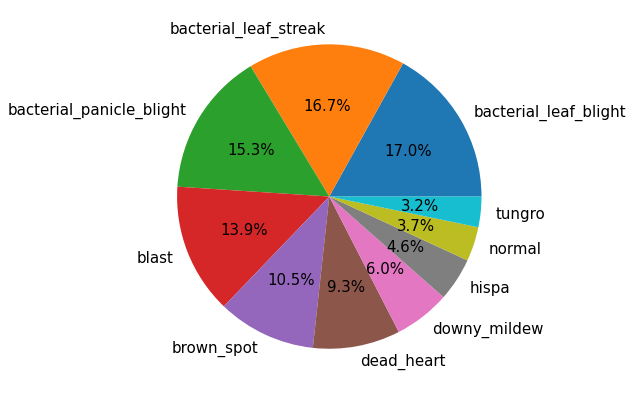

In [ ]:
# graph visualization
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# target label
label = list(df['label'].unique())

# pie graph
plt.pie(df['label'].value_counts(), labels=label, autopct='%.1f%%')
plt.show()

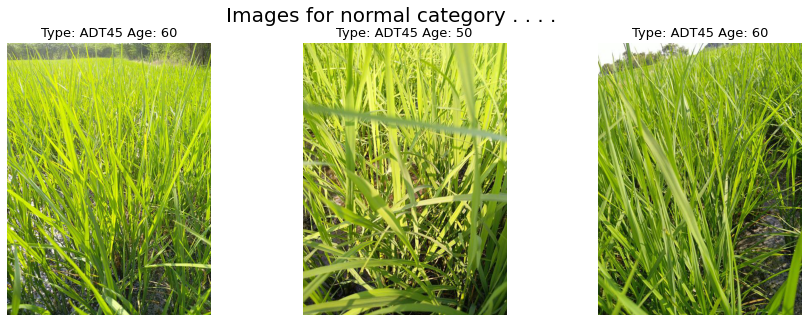

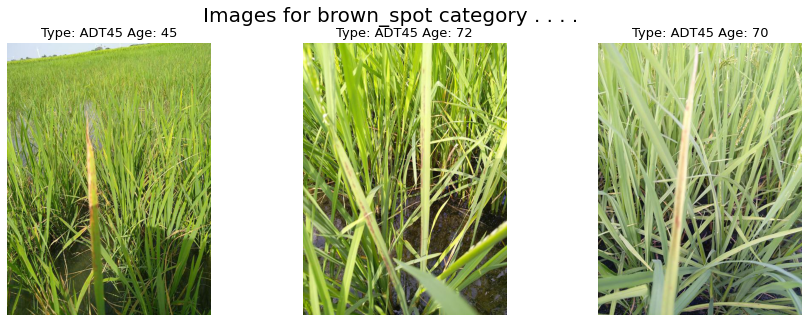

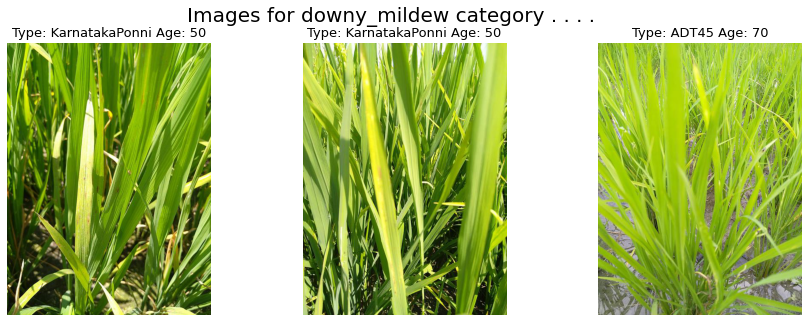

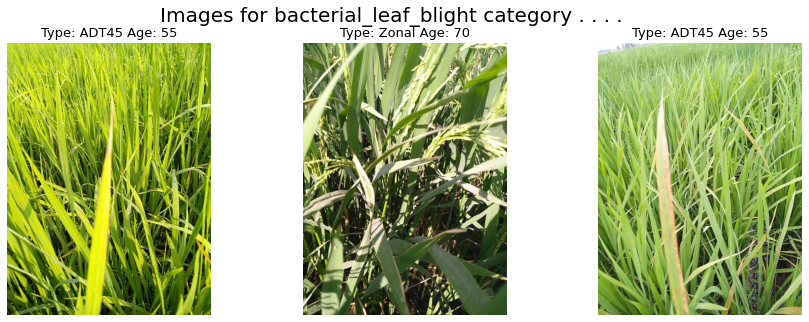

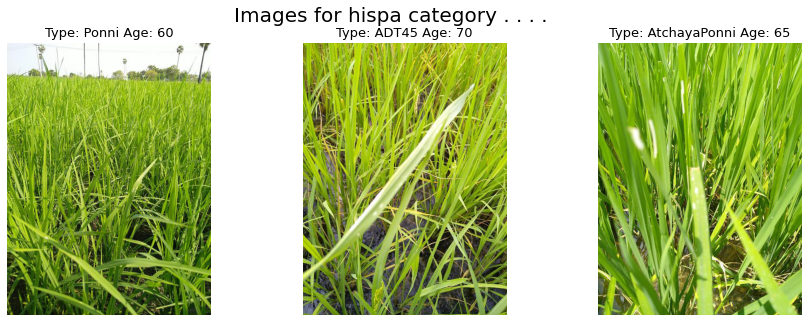

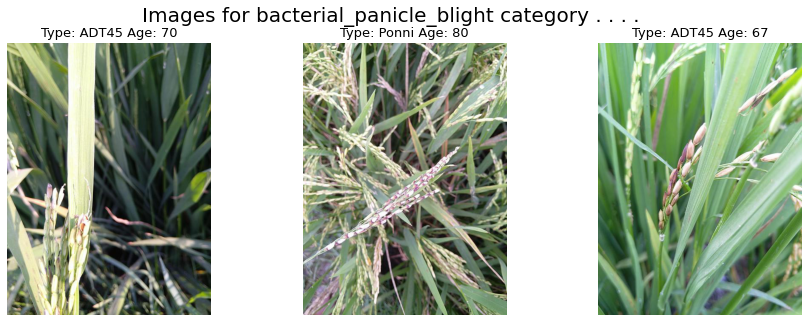

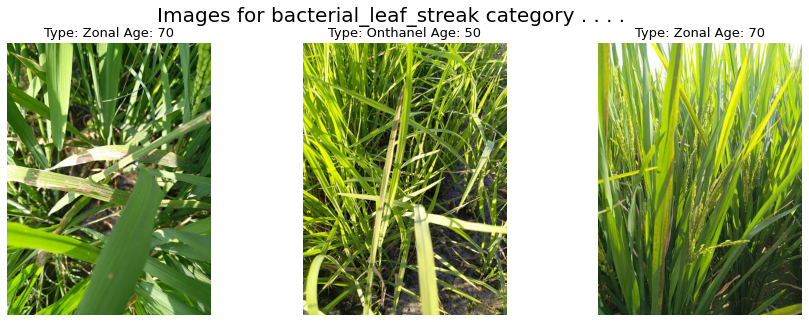

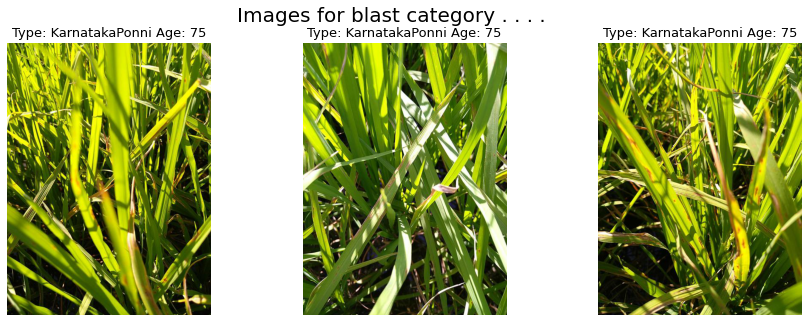

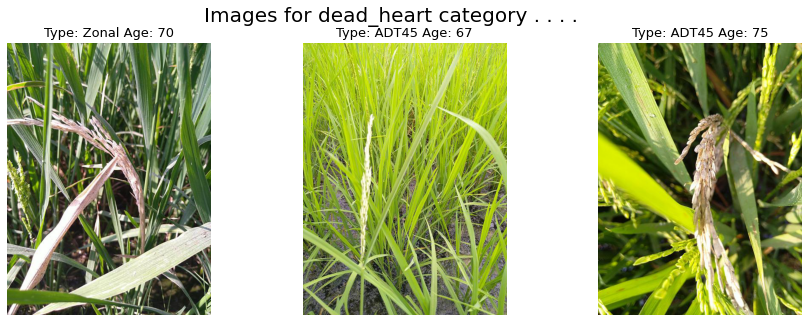

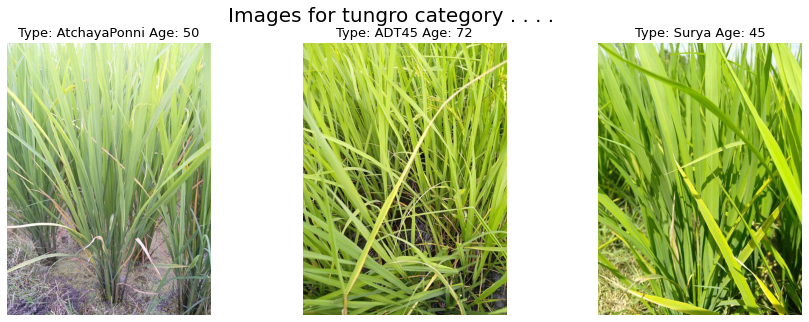

In [ ]:
base_path = '/content/drive/MyDrive/Section4/train_images'
diseases = os.listdir(base_path)


for dis in diseases:
    disease_specific = df[df['label']==dis]
    
    index_list = disease_specific.index
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'Images for {dis} category . . . .', fontsize=20)
    for i in range(3):
        index = np.random.randint(0,len(index_list))
        index = index_list[index]
        data = df.iloc[index]
        
        
        image_path = f'{base_path}/{dis}/{data[0]}'
        
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
        ax[i].set_title(f'Type: {data[2]} Age: {data[3]}', fontsize=13)
        ax[i].axis('off')  #As all the images are of 480 x 640 dimension as per the data section.
    plt.show()

위 와 같이 10개의 category 별 이미지를 확인하였고, label별로 분류하여 시각화해보았다.

## 2. Data manipulating

basemodel 생성에 사용할 데이터를 정의한다.


각 라벨의 비율에 맞게 train/validation/test 셋을 분리하고 아래 모델로 간단하게 모델링을 진행해보았다.
- 3개의 은닉층을 가진 CNN



### 데이터 분리
label의 비율을 고려하여 Data set split

In [ ]:
# 균형있는 data split을 위한 작업 진행

paths = []
labels = []

for root, dirs, filename in os.walk('/content/drive/MyDrive/Section4/train_images'):
    
    # root directory를 제외하고 각 diretory 중 image가 있으면 레이블링 진행
    for name in filename:
        if '.jpg' in name:
            path = root + '/' + name
            paths.append(path)

            if 'brown_spot' in path:
                labels.append('brown_spot')

            elif 'downy_mildew' in path:
                labels.append('downy_mildew')

            elif 'bacterial_leaf_blight' in path:
                labels.append('bacterial_leaf_blight')

            elif 'hispa' in path:
                labels.append('hispa')

            elif 'bacterial_panicle_blight' in path:
                labels.append('bacterial_panicle_blight')

            elif 'bacterial_leaf_streak' in path:
                labels.append('bacterial_leaf_streak')

            elif 'blast' in path:
                labels.append('blast')

            elif 'dead_heart' in path:
                labels.append('dead_heart')

            elif 'tungro' in path:
                labels.append('tungro')

            elif 'normal' in path:
                labels.append('normal')
                
            else:
                labels.append('N/A')

data_df = pd.DataFrame({'path':paths, 'label':labels})

In [ ]:
data_df.shape

(10426, 2)

In [ ]:
data_df['label'].value_counts()

normal                      1764
blast                       1757
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df['label'], random_state=42)

In [ ]:
train_df.shape, test_df.shape

((9383, 2), (1043, 2))

아래 그래프를 보면 train set과 validation set 이 label의 비율에 맞춰 분리되어있음을 확인할 수 있다.

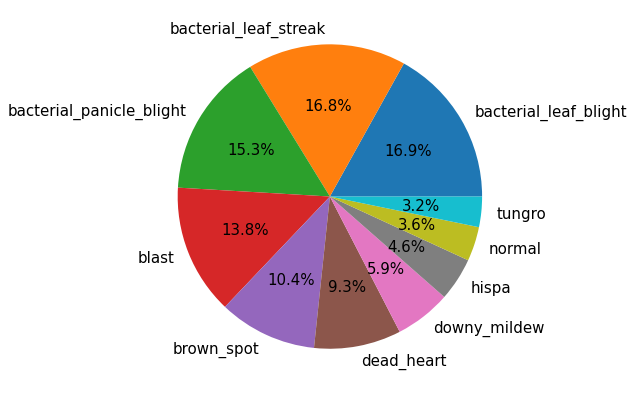

In [ ]:
# graph visualization
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# pie graph
plt.pie(train_df['label'].value_counts(), labels=label, autopct='%.1f%%')
plt.show()

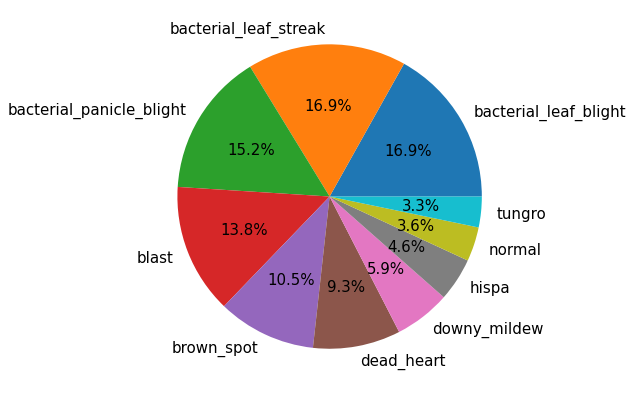

In [ ]:
# graph visualization
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# pie graph
plt.pie(test_df['label'].value_counts(), labels=label, autopct='%.1f%%')
plt.show()

In [ ]:
train, val = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [ ]:
train.shape, val.shape

((7506, 2), (1877, 2))

### image data 변환 및 학습 진행
아래 5가지의 방법으로 baseline을 진행하였다.
1. image data array로 import
2. data rescaling
3. CNN 모델 구축
4. 모델 학습
5. 모델 평가

In [ ]:
# 데이터 종류에 맞게 ImageDataGenerator 객체 생성
tr_gen = ImageDataGenerator(horizontal_flip=True, rescale=1/255., shear_range=0.2, zoom_range=0.2)
val_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

# 데이터 종류에 맞는 Pandas.DataFrame으로부터 Numpy Array Iterator 생성
tr_flow_gen = tr_gen.flow_from_dataframe(dataframe=train, x_col='path', y_col='label',
                                        target_size=(256, 256), class_mode='sparse',
                                        shuffle=True)
val_flow_gen = val_gen.flow_from_dataframe(dataframe=val, x_col='path', y_col='label',
                                          target_size=(256, 256), class_mode='sparse',
                                          shuffle=False)
test_flow_gen = test_gen.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label',
                                            target_size=(256, 256), class_mode='sparse',
                                            suffle=False)

Found 7506 validated image filenames belonging to 10 classes.
Found 1877 validated image filenames belonging to 10 classes.
Found 1043 validated image filenames belonging to 10 classes.


In [ ]:
# baseline model 정의
def create_bs_model(verbose=False):
    bs_model = Sequential([
                Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(256, 256, 3)),
                MaxPooling2D(2, 2),
                Conv2D(128, (3, 3), padding='same', activation='relu'),
                Flatten(),
                Dense(256, activation='relu'),
                Dense(10, activation='softmax')
    ])

    if verbose:
        bs_model.summary()

    return bs_model

In [ ]:
bs_model = create_bs_model(verbose=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 flatten (Flatten)           (None, 2097152)           0         
                                                                 
 dense (Dense)               (None, 256)               536871168 
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

In [ ]:
bs_model.compile(optimizer=Adam(lr=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

bs_model.fit(tr_flow_gen, epochs=1, validation_data=val_flow_gen, callbacks=[tqdm_callback])

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/118           ETA: ?s - 

118/118 [==============================] - 3745s 32s/step - loss: 1.9498 - accuracy: 0.3119 - val_loss: 1.7800 - val_accuracy: 0.3863


In [ ]:
bs_model.evaluate(test_flow_gen)

17/17 [==============================] - 459s 29s/step - loss: 1.7540 - accuracy: 0.3941


[1.7539544105529785, 0.3940556049346924]

accuray : 0.3941 로 매우 저조한 성적의 모델이 구현되었다.


다음 모델로는 사전학습 모델(VGG)와 간단한 완전 연결 신경망을 추가하여 학습을 진행하였다.

In [ ]:
# 사전학습 모델 사용

pretrained_model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# 사전 학습 모델 위에 완전 연결 신경망 추가
# VGG

model_vgg = Sequential()
model_vgg.add(pretrained_model)
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Dense(128,activation='relu'))
model_vgg.add(Dense(10,activation='softmax'))

model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,781,642
Trainable params: 14,781,642
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_vgg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_vgg.fit(tr_flow_gen,
          validation_data=val_flow_gen,
          callbacks=[tqdm_callback],
          epochs=10)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/235           ETA: ?s - 

Epoch 1/10
235/235 [==============================] - 205s 869ms/step - loss: 2.1059 - accuracy: 0.2225 - val_loss: 1.9944 - val_accuracy: 0.2552
Epoch 2/10


0/235           ETA: ?s - 

Epoch 2/10
235/235 [==============================] - 204s 868ms/step - loss: 1.9312 - accuracy: 0.3002 - val_loss: 1.7249 - val_accuracy: 0.3980
Epoch 3/10


0/235           ETA: ?s - 

Epoch 3/10
235/235 [==============================] - 203s 864ms/step - loss: 1.6492 - accuracy: 0.4334 - val_loss: 1.5683 - val_accuracy: 0.4566
Epoch 4/10


0/235           ETA: ?s - 

Epoch 4/10
235/235 [==============================] - 204s 866ms/step - loss: 1.4996 - accuracy: 0.4840 - val_loss: 1.4372 - val_accuracy: 0.5147
Epoch 5/10


0/235           ETA: ?s - 

Epoch 5/10
235/235 [==============================] - 205s 870ms/step - loss: 1.4024 - accuracy: 0.5147 - val_loss: 1.3316 - val_accuracy: 0.5466
Epoch 6/10


0/235           ETA: ?s - 

Epoch 6/10
235/235 [==============================] - 205s 873ms/step - loss: 1.3459 - accuracy: 0.5334 - val_loss: 1.3234 - val_accuracy: 0.5445
Epoch 7/10


0/235           ETA: ?s - 

Epoch 7/10
235/235 [==============================] - 206s 874ms/step - loss: 1.2743 - accuracy: 0.5549 - val_loss: 1.2722 - val_accuracy: 0.5743
Epoch 8/10


0/235           ETA: ?s - 

Epoch 8/10
235/235 [==============================] - 208s 882ms/step - loss: 1.2788 - accuracy: 0.5596 - val_loss: 1.4669 - val_accuracy: 0.5535
Epoch 9/10


0/235           ETA: ?s - 

Epoch 9/10
235/235 [==============================] - 207s 879ms/step - loss: 1.2561 - accuracy: 0.5581 - val_loss: 1.2461 - val_accuracy: 0.5850
Epoch 10/10


0/235           ETA: ?s - 

Epoch 10/10
235/235 [==============================] - 204s 865ms/step - loss: 1.1854 - accuracy: 0.5889 - val_loss: 1.1485 - val_accuracy: 0.6201


In [ ]:
model_vgg.evaluate(test_flow_gen)

33/33 [==============================] - 11s 319ms/step - loss: 1.0634 - accuracy: 0.6232


[1.0634433031082153, 0.6232023239135742]

학습을 진행하여 보니 basemodel의 학습을 진행할 때보다 속도가 월등히 빨라지는것을 확인할 수 있었고, accuracy 또한 0.6232 로 큰폭으로 상승하는것을 확인할 수 있었다.




하지만, 여전히 0.6232 라는 아쉬운 accuracy를 기록하였기 때문에, MobileNetV2를 사용한 사전학습 모델과 좀 더 깊어진 완전신경망을 참고하여 모델링을 진행하였다.

### final model 작성

1. MobileNetV2 모델을 사용한 사전학습 모델 사용
2. 이전보다 깊은 완전 신경망 연결
    - 기울기 소실문제를 방지하기 위해 배치 정규화 사용
    - 과적합 방지를 위해 Dropout 사용

In [ ]:
labels = os.listdir('/content/drive/MyDrive/Section4/train_images')
img_size = 400

train_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/Section4/train_images',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=True,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='training',
    seed=22
)


val_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/Section4/train_images',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='validation',
    seed=22
)

Found 10426 files belonging to 10 classes.
Using 9384 files for training.
Found 10426 files belonging to 10 classes.
Using 1042 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

def get_model(base, preprocessor, img_size):    
    inputs = tf.keras.Input(shape=(img_size,img_size,3))
    x = RandomFlip('horizontal')(inputs)
    x = preprocessor(x)
    x = base(x)

    x = tfl.Flatten()(x)
    x = tfl.Dense(1024, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu')(x)
    x = tfl.Dropout(0.15)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(64, activation='relu')(x)
    x = tfl.Dropout(0.3)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),
                                         include_top=False,
                                         weights='imagenet')

pre_trained_model.trainable = False

In [ ]:
model_v2 = get_model(pre_trained_model, preprocess_input, img_size)

model_v2.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_v2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 400, 400, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 400, 400, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 400, 400, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 13, 13, 1280)     2257984   
 ional)                                                          
                                                           

In [ ]:
history = model_v2.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5, verbose=1)

Epoch 1/5
147/147 [==============================] - 605s 4s/step - loss: 1.2682 - accuracy: 0.5921 - val_loss: 0.7675 - val_accuracy: 0.7620
Epoch 2/5
147/147 [==============================] - 33s 220ms/step - loss: 0.5056 - accuracy: 0.8497 - val_loss: 0.3239 - val_accuracy: 0.9117
Epoch 3/5
147/147 [==============================] - 33s 220ms/step - loss: 0.2697 - accuracy: 0.9268 - val_loss: 0.1782 - val_accuracy: 0.9530
Epoch 4/5
147/147 [==============================] - 33s 220ms/step - loss: 0.1733 - accuracy: 0.9547 - val_loss: 0.2513 - val_accuracy: 0.9290
Epoch 5/5
147/147 [==============================] - 34s 222ms/step - loss: 0.1186 - accuracy: 0.9695 - val_loss: 0.0855 - val_accuracy: 0.9760


## 결론

final 모델의 accuracy는 0.9695 로 높은 accuracy를 도출할 수 있었다.

딥러닝 모델을 구현할 때는 데이터의 특징을 확인하고, 학습률을 높여 더 좋은 신경망을 구축할 수 있게 상황에 맞는 하이퍼파라미터 설정이 중요하다는것을 알 수 있다.